## Welcome to Week 4, Day 4

This is the start of an AWESOME project! Really simple and very effective.

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.agents import Tool

from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [2]:
load_dotenv(override=True)

True

### Asynchronous LangGraph

To run a tool:  
Sync: `tool.run(inputs)`  
Async: `await tool.arun(inputs)`

To invoke the graph:  
Sync: `graph.invoke(state)`  
Async: `await graph.ainvoke(state)`

In [3]:
class State(TypedDict):
    
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

## Extra installation step - if you don't have Node and Playwright on your computer

Next, you need to install NodeJS and Playwright on your computer if you don't already have them. Please see instructions here:

[Node and Playwright setup](../setup/SETUP-node.md)

## And now - after Installing Playwright, a heads up for Windows PC Users:

While executing the next few cells, you might hit a problem with the Playwright browser raising a NotImplementedError.

This should work when we move to python modules, but it can cause problems in Windows in a notebook.

If you it this error and would like to run the notebook, you need to make a small change which seems quite hacky! You need to do this AFTER installing Playwright (prior cells)

1. Right click in `.venv` in the File Explorer on the left and select "Find in folder"
2. Search for `asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())`  
3. That code should be found in a line of code in a file called `kernelapp.py`
4. Comment out the entire else clause that this line is a part of - see the fragment below. Be sure to have the "pass" statement after the ImportError line.
5. Restart the kernel by pressing the "Restart" button above

```python
        if sys.platform.startswith("win") and sys.version_info >= (3, 8):
            import asyncio
 
            try:
                from asyncio import WindowsProactorEventLoopPolicy, WindowsSelectorEventLoopPolicy
            except ImportError:
                pass
                # not affected
           # else:
            #    if type(asyncio.get_event_loop_policy()) is WindowsProactorEventLoopPolicy:
                    # WindowsProactorEventLoopPolicy is not compatible with tornado 6
                    # fallback to the pre-3.8 default of Selector
                    # asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())
```

Thank you to student Nicolas for finding this, and to Kalyan, Yaki, Zibin and Bhaskar for confirming that this worked for them! And to Vladislav for the extra pointers.

As an alternative, you can just move to a Python module (which we do anyway in Day 5)

In [7]:
# Introducing nest_asyncio
# Python async code only allows for one "event loop" processing aynchronous events.
# The `nest_asyncio` library patches this, and is used for special situations, if you need to run a nested event loop.

import nest_asyncio
nest_asyncio.apply()

### The LangChain community

One of the remarkable things about LangChain is the rich community around it.

Check this out:


In [8]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

# If you get a NotImplementedError here or later, see the Heads Up at the top of the notebook

async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [9]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/dynamodenis/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/dynamodenis/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/dynamodenis/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/dynamodenis/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/dynamodenis/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>
get_elements=async_browser=<Browser type=<BrowserType name=chromium executable_p

In [12]:
tool_dict = {tool.name:tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

    
await navigate_tool.arun({"url": "https://www.cnn.com"})
text = await extract_text_tool.arun({})

In [13]:
import textwrap
print(textwrap.fill(text))

Breaking News, Latest News and Videos | CNN CNN values your feedback
1. How relevant is this ad to you? 2. Did you encounter any technical
issues? No Video player was slow to load content Video content never
loaded Ad froze or did not finish loading Video content did not start
after ad Audio on ad was too loud Other issues Ad never loaded Ad
prevented/slowed the page from loading Content moved around while ad
loaded Ad was repetitive to ads I've seen previously Other issues
Cancel Submit Thank You! Your effort and contribution in providing
this feedback is much
appreciated. Close Ad Feedback Close icon US World Politics Business
Health Entertainment Style Travel Sports Science Climate Weather
Ukraine-Russia War Israel-Hamas War Games More US World Politics
Business Health Entertainment Style Travel Sports Science Climate
Weather Ukraine-Russia War Israel-Hamas War Games Watch Listen Live TV
Subscribe Sign in My Account Settings Newsletters Topics you follow
Sign out Your CNN account Si

In [14]:
all_tools = tools + [tool_push]

In [15]:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(all_tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


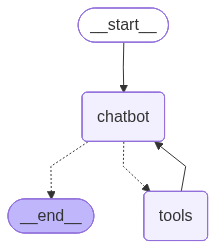

In [16]:

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
